# Swipe Gesture Classification with LSTM

Train an LSTM model to classify swipe gestures:
- 0: Non-gesture
- 1: Swipe Left
- 2: Swipe Right

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/Users/dikaizm/Documents/PROGRAMMING/ml-ai/hand-gesture-recognition-mediapipe/.venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Configuration

In [2]:
# Data paths - UPDATE THESE AFTER RE-COLLECTING DATA WITH NEW FEATURES
DATASET_PATHS = [
    '../data/swipe_gesture_20260102_134712.csv',
    '../data/swipe_gesture_20260103_032002.csv',
    '../data/swipe_gesture_20260106_051821.csv',
    '../data/swipe_gesture_20260110_162518.csv',
    '../data/swipe_gesture_20260110_172552.csv',
]

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')

# Model paths
MODEL_SAVE_PATH = f'../models/{current_time}/swipe_gesture_classifier.keras'
TFLITE_SAVE_PATH = f'../models/{current_time}/swipe_gesture_classifier.tflite'
TFJS_SAVE_DIR = f'../models/{current_time}/swipe_gesture_tfjs'

# Model parameters
NUM_CLASSES = 3  # Non-gesture, Swipe Left, Swipe Right
TIME_STEPS = 16  # History window size
FEATURES_PER_STEP = 16  # [x, y, dx, dy, angle, dtheta] + 5 fingertips × 2 coords

# Feature indices for reference:
# 0-1: palm_x, palm_y (normalized by scale)
# 2-3: dx, dy (velocity)
# 4-5: angle, dtheta (orientation)
# 6-7: thumb tip (x, y relative to palm)
# 8-9: index tip
# 10-11: middle tip
# 12-13: ring tip
# 14-15: pinky tip

## Load and Preprocess Data

In [3]:
# Load data
datasets = []
for path in DATASET_PATHS:
    data = np.atleast_2d(
        np.loadtxt(path, delimiter=',', dtype='float32')
    )
    datasets.append(data)

data = np.vstack(datasets)

# Expected columns: 1 (label) + TIME_STEPS * FEATURES_PER_STEP
expected_cols = 1 + TIME_STEPS * FEATURES_PER_STEP
print(f"Data shape: {data.shape}")
print(f"Expected: (samples, {expected_cols})")

if data.shape[1] != expected_cols:
    print(f"\n⚠️  WARNING: Data has {data.shape[1]} columns, expected {expected_cols}")
    print("Make sure you collected data with the new 16-feature format!")

# Split into labels and features
y = data[:, 0].astype(int)
X = data[:, 1:]

print(f"\nLabels: {y.shape}")
print(f"Features: {X.shape}")
print(f"\nClass distribution:")
for i in range(NUM_CLASSES):
    count = np.sum(y == i)
    print(f"  Class {i}: {count} samples ({100*count/len(y):.1f}%)")

Data shape: (5441, 257)
Expected: (samples, 257)

Labels: (5441,)
Features: (5441, 256)

Class distribution:
  Class 0: 2298 samples (42.2%)
  Class 1: 1730 samples (31.8%)
  Class 2: 1413 samples (26.0%)


In [4]:
# Reshape for LSTM: (samples, time_steps, features)
X_reshaped = X.reshape(-1, TIME_STEPS, FEATURES_PER_STEP)
print(f"Reshaped X: {X_reshaped.shape}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")

Reshaped X: (5441, 16, 16)

Train: (4352, 16, 16), Test: (1089, 16, 16)


## Build LSTM Model

In [5]:
# # Using Conv1D instead of LSTM for full TFLite compatibility
# # Note: Using explicit input_shape in first layer instead of Input layer for TFJS compatibility
# model = tf.keras.Sequential([
#     # First Conv1D layer with input_shape (TFJS compatible)
#     tf.keras.layers.Conv1D(32, kernel_size=3, padding='same', activation='relu',
#                           input_shape=(TIME_STEPS, FEATURES_PER_STEP)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.3),
    
#     tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dropout(0.3),
    
#     # Dense layers
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# model.summary()

In [ ]:
# Optimized Conv1D model for handling 16 features and 3 motion gestures
# TFLite/TFJS compatible

model = tf.keras.Sequential([
    # Input normalization - using input_shape for TFJS compatibility
    tf.keras.layers.BatchNormalization(input_shape=(TIME_STEPS, FEATURES_PER_STEP)),
    
    # First Conv1D block - captures short-term temporal patterns
    tf.keras.layers.Conv1D(48, kernel_size=3, padding='same', activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    # Second Conv1D block - captures mid-range motion dynamics
    tf.keras.layers.Conv1D(64, kernel_size=5, padding='same', activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    # Third Conv1D block - captures longer temporal patterns
    tf.keras.layers.Conv1D(64, kernel_size=7, padding='same', activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    # Fourth Conv1D block - refines high-level gesture patterns
    tf.keras.layers.Conv1D(48, kernel_size=3, padding='same', activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    
    # Dense layers for classification - reduced size
    tf.keras.layers.Dense(32, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

/Users/dikaizm/Documents/PROGRAMMING/ml-ai/hand-gesture-recognition-mediapipe/.venv/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 16, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 16, 48)         │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 48)         │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16, 64)         │        15,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 64)         │        28,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 16, 48)         │         9,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 48)         │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 48)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,531 (228.64 KB)

 Trainable params: 57,987 (226.51 KB)

 Non-trainable params: 544 (2.12 KB)

In [7]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Train Model

In [8]:
# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH, 
        save_best_only=True, 
        monitor='val_accuracy',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=30, 
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5, 
        patience=10, 
        verbose=1
    )
]

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/200
134/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6679 - loss: 1.0629
Epoch 1: val_accuracy improved from None to 0.92103, saving model to ../models/20260110_173026/swipe_gesture_classifier.keras

Epoch 1: finished saving model to ../models/20260110_173026/swipe_gesture_classifier.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7842 - loss: 0.7980 - val_accuracy: 0.9210 - val_loss: 0.5446 - learning_rate: 0.0010
Epoch 2/200
119/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8966 - loss: 0.5233
Epoch 2: val_accuracy improved from 0.92103 to 0.94674, saving model to ../models/20260110_173026/swipe_gesture_classifier.keras

Epoch 2: finished saving model to ../models/20260110_173026/swipe_gesture_classifier.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9062 - loss: 0.5039 - val_accuracy: 0.9467 - val_loss: 0.3795 - learning_rate: 0.0010
Epoch 3/200
119/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9300 - loss: 0.4618
Epoch 3: val_accur

## Evaluate Model

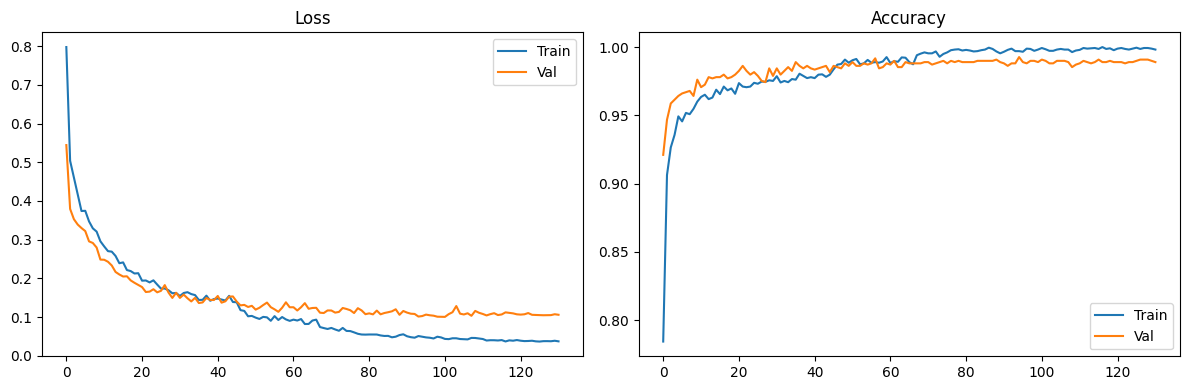

In [10]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Val')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Val')
ax2.set_title('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [11]:
# Evaluation
y_pred = model.predict(X_test).argmax(axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-gesture', 'Swipe Left', 'Swipe Right']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

 Non-gesture       1.00      1.00      1.00       460
  Swipe Left       0.98      0.99      0.99       346
 Swipe Right       0.99      0.98      0.98       283

    accuracy                           0.99      1089
   macro avg       0.99      0.99      0.99      1089
weighted avg       0.99      0.99      0.99      1089


Confusion Matrix:
[[460   0   0]
 [  1 343   2]
 [  0   7 276]]


## Convert to TFLite

In [12]:
# Load best model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Convert to TFLite (standard ops only - fully compatible)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save
with open(TFLITE_SAVE_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {TFLITE_SAVE_PATH}")
print(f"Model size: {len(tflite_model) / 1024:.1f} KB")

INFO:tensorflow:Assets written to: /var/folders/hb/b1p7kpgj4s759vkptsfqzxzw0000gn/T/tmpji2aafb3/assets


INFO:tensorflow:Assets written to: /var/folders/hb/b1p7kpgj4s759vkptsfqzxzw0000gn/T/tmpji2aafb3/assets


Saved artifact at '/var/folders/hb/b1p7kpgj4s759vkptsfqzxzw0000gn/T/tmpji2aafb3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16, 16), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  13699422672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699421328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699423440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699424016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699423824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699423056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699419984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699422480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699422288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699417488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13699432080: Ten

W0000 00:00:1768041109.270423 3529921 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1768041109.270667 3529921 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1768041109.280415 3529921 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


## Convert to TensorFlow.js

In [13]:
import os
import json
import tensorflowjs as tfjs

# Create output directory
os.makedirs(TFJS_SAVE_DIR, exist_ok=True)

# Load the model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Create a new model without regularizers (regularizers only affect training, not inference)
model_config = model.get_config()

# Remove regularizers from all layers
for layer_config in model_config['layers']:
    if 'kernel_regularizer' in layer_config['config']:
        layer_config['config']['kernel_regularizer'] = None
    if 'bias_regularizer' in layer_config['config']:
        layer_config['config']['bias_regularizer'] = None
    if 'activity_regularizer' in layer_config['config']:
        layer_config['config']['activity_regularizer'] = None

# Reconstruct model without regularizers
model_no_reg = tf.keras.Sequential.from_config(model_config)

# Copy the trained weights
model_no_reg.set_weights(model.get_weights())

# Convert to TensorFlow.js
tfjs.converters.save_keras_model(model_no_reg, TFJS_SAVE_DIR)

# Fix Keras 3 to TFJS compatibility - replace keys in model.json
model_json_path = os.path.join(TFJS_SAVE_DIR, 'model.json')
with open(model_json_path, 'r') as f:
    model_json = json.load(f)

# Replace Keras 3 keys with TFJS-compatible keys
model_json_str = json.dumps(model_json)
model_json_str = model_json_str.replace('"batch_shape"', '"batchInputShape"')
model_json_str = model_json_str.replace('"build_input_shape"', '"buildInputShape"')
model_json = json.loads(model_json_str)

# Save the fixed model.json
with open(model_json_path, 'w') as f:
    json.dump(model_json, f)

print(f"✅ TensorFlow.js model saved to: {TFJS_SAVE_DIR}")
print(f"✅ Removed regularizers (only needed for training)")
print(f"✅ Fixed Keras 3 keys for TFJS compatibility")

# List output files
for f in os.listdir(TFJS_SAVE_DIR):
    filepath = os.path.join(TFJS_SAVE_DIR, f)
    size = os.path.getsize(filepath) / 1024
    print(f"  - {f} ({size:.1f} KB)")

/Users/dikaizm/Documents/PROGRAMMING/ml-ai/hand-gesture-recognition-mediapipe/.venv/lib/python3.11/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


failed to lookup keras version from the file,
    this is likely a weight only file
✅ TensorFlow.js model saved to: ../models/20260110_173026/swipe_gesture_tfjs
✅ Removed regularizers (only needed for training)
✅ Fixed Keras 3 keys for TFJS compatibility
  - model.json (14.2 KB)
  - group1-shard1of1.bin (228.6 KB)


## Test TFLite Model

In [14]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=TFLITE_SAVE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])
print("Output shape:", output_details[0]['shape'])

Input shape: [ 1 16 16]
Output shape: [1 3]


/Users/dikaizm/Documents/PROGRAMMING/ml-ai/hand-gesture-recognition-mediapipe/.venv/lib/python3.11/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [15]:
# Test on a sample
test_sample = X_test[0:1]
interpreter.set_tensor(input_details[0]['index'], test_sample)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])

print(f"Predicted: {output.argmax()}")
print(f"Actual: {y_test[0]}")
print(f"Probabilities: {output[0]}")

Predicted: 1
Actual: 1
Probabilities: [2.2161961e-05 9.9997175e-01 6.0369935e-06]
